In [6]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# Let's make a Neural Network! ~~
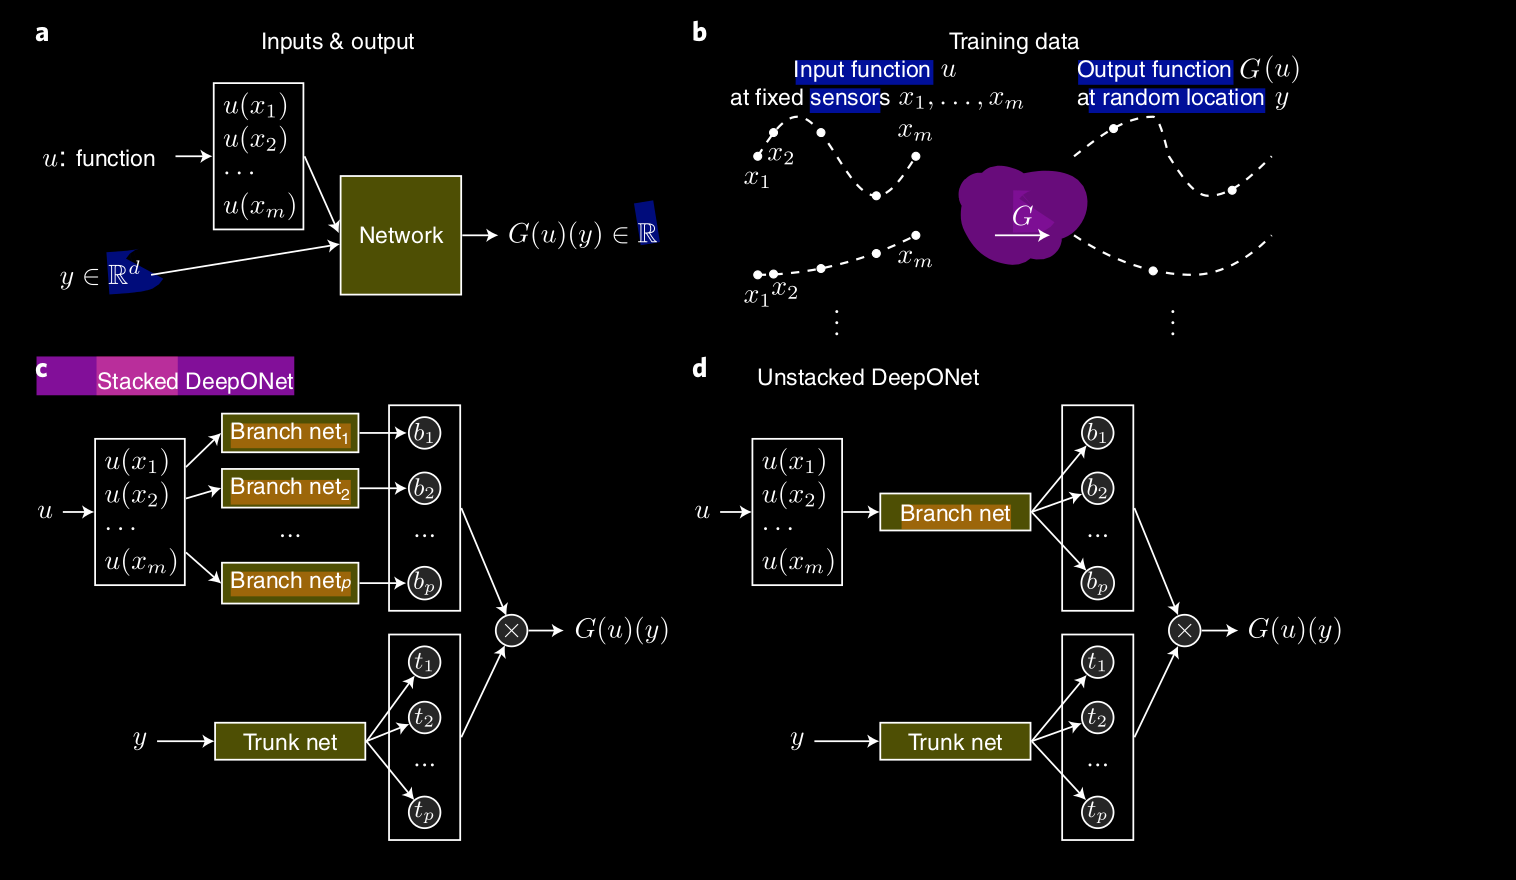

In [5]:
class StackedBranchNet(nn.Module):
    def __init__(self, num_sensors, num_hidden, hidden_size, output_size):
        '''
        num_sensors - we decide in m fixed values of x to sample from different u(x)s
        Here all these inputs share a common set of parameters
        
        '''
        super("StackedBranchNet").__init__()
        
        self.input_size = num_sensors
        self.num_hidden = num_hidden
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # NN Architecture ~~
        
        self.input_fc = nn.Linear(self.input_size, hidden_size)
        
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            hfc = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(hfc)
        
        self.output_fc = nn.Linear(hidden_size, output_size)
        
        # Activation is just LeakyReLU for now
        self.activation = nn.LeakyReLU
        
        
    def forward(self, x):
        out = self.input_fc(x)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        out = self.output_fc(out)
        return out
    
    
class TrunkNet(nn.Module):
    def __init__(self, num_hidden, hidden_size, output_size):
        super("TrunkNet").__init__()
        
        self.num_hidden = num_hidden
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # ~~ NN Architecture ~~
        
        self.input_fc = nn.Linear(1, hidden_size)
        
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            hfc = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(hfc)
        
        self.output_fc = nn.Linear(hidden_size, output_size)
        
        # Activation is just LeakyReLU for now
        self.activation = nn.LeakyReLU
        
        
    def forward(self, x):
        out = self.input_fc(x)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        out = self.output_fc(out)
        return out     
   
class YoOpNet(nn.Module):
    def __init__(self, 
                 num_sensors = 100, 
                 num_hidden_branch = 1, 
                 hidden_size_branch = 50, 
                 output_size_branch = 30, 
                 num_hidden_trunk = 1, 
                 hidden_size_trunk = 30, 
                 output_size_trunk = 30 
            ):
        super("YoOpNet").__init__()        
        
        self.branch_net = StackedBranchNet(num_sensors, num_hidden_branch, hidden_size_branch, output_size_branch)
        self.trunk_net = TrunkNet(num_hidden_trunk, hidden_size_trunk, output_size_trunk)
        
        self.combined_fc = nn.Linear(output_size_branch + output_size_trunk, 1)
    
    def forward(self, x_brnach, x_trunk):
        out_branch = self.branch_net(x_brnach)
        out_trunk = self.trunk_net(x_trunk)
        combined = torch.cat(out_branch, out_trunk)
        out = self.combined_fc(combined)
        return out    

# But what about the data ¯\\_(ツ)_/¯

1. We need to generate triplets of (u, y, G(u)(y)) where:
    - u is a function of x - we sample u(x) values from the sensor positions
    - G(u) is the anti-derivative of u
    - y is in the domain to G(u)

2. Let's start with a bunch of functions that will be G(u)...
    We will get u(x) by differentiating these functions
    - Let's just do cubic polynomials for now

In [14]:
from torch.utils.data import Dataset, DataLoader

class CubicPolynomialDataset(Dataset):
    def __init__(self):
        super().__init__()
        
        # Let's start by generating a bunch of random cubic polynomials coeffs and that of their derivatives
        domain_limits = [-100, 101]
        sampling_window = 10
        how_many_in_a_window = 20
        Ga = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])
        Gb = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])
        Gc = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])
        Gd = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])

        ua = 3*Ga
        ub = 2*Gb
        uc = Gc
        
        # Sensor locations 
        num_sensors = 100
        sensor_values = np.linspace(domain_limits[0], domain_limits[1], num_sensors)
        
        # x_g is the input to the trunk network
        num_x_g_for_each_u = 100